## Analyzing: Hot water cooled electronics: Exergy analysis and waste heat reuse feasibility

This article was published in the International Journal of Heat and Mass Transfer in 2012: https://www.sciencedirect.com/science/article/pii/S0017931012004553?via%3Dihub

They use a flow loop to cool a heat sink that is attached to a computer chip:

<!-- ![title](figure1.png) -->

They perform first law (energy based) and second law (exergy based) analysis to understand how much waste heat they can recover and the quality of that recovered heat for potential reuse in building heating. They state that data centers require significant cooling, which is currently achieved with air. That air cooling requires a significant amount of energy. They state that liquid cooling should provide better heat transfer efficiency, and they hypothesize that if they use "hot water" to cool the chips, that this would keep the waste heat output from computers at higher exergy. This means it may have better potential for resuse, for example, in building heating. Instead of requiring extra energy for cooling, the cooling process itself can actulally bring a benefit by reducing the building heating energy requirements.

### Analysis
- define second law efficiency
- determine exergy terms
- calculate second law efficiency for different conditions

Second law efficiency can be defined as:
$$\eta_\text{II} = \frac{\text{Exergy recovered}}{\text{Exergy expended}} $$

It is instructive to first look at the second law efficiency of a simple electric heater:
$$\eta_\text{II,electric heater} = \frac{\dot{X}_\text{recovered}}{\dot{X}_\text{expended}} = \frac{\dot{X}_\text{heat}}{\dot{W}_\text{e}} = \frac{\dot{Q}_\text{e} \left(1 - T_0/T_\text{H} \right)}{\dot{W}_\text{e}} = 1 - \frac{T_0}{T_\text{H}} $$

In the case of electronics cooling, there is exergy expended on running the computer and pump and the recovered exergy is heat exergy:

$$\eta_\text{II} = \frac{\dot{X}_\text{recovered}}{\dot{X}_\text{expended}} = \frac{\dot{X}_\text{outlet}}{\dot{X}_\text{inlet} + \dot{X}_\text{el} + \dot{P}_\text{pump}} $$


We can write the inlet and outlet exergy terms using this equation:

$$ \dot{X}_\text{flow} = \dot{m}\left[ 
\left(h - h_0\right) - T_0 \left( s - s_0 \right) \right]$$

In the study, they say that 100 W of electrical power is used for the processor chip, which is pure exergy. 

In [38]:
Xel_W = 100

The maximum upper temperature where the chip can operate safely is this temperature:

In [39]:
Tmax_K = 85+273

They say that the pump has a flow rate of 1 L/min and that that the pump requires 0.24 W of power. The power for a pump can be estimated as $$\dot{P} = \Delta p \dot{V} $$, which implies that the pressure drop was:

In [40]:
V_m3perS = (1/1000)/60
P_W = 0.24

dP_Pa = P_W/V_m3perS
print('The pressure drop along the flow path is: {0:1.4f} Pa'.format(dP_Pa))

The pressure drop along the flow path is: 14400.0000 Pa


To calculate the inlet and outlet exergies, we have to define the water properties.

In [41]:
!pip install iapws

In [42]:
from iapws import IAPWS97

The dead state temperature is:

In [43]:
T0_K = 273+20
p0_MPa = 1e5/1e6

In [44]:
water0 = IAPWS97(T=T0_K,P=p0_MPa)

In [45]:
v0_m3Perkg = water0.v
h0_kJperKg = water0.h
s0_kJperKgperK = water0.s

In [46]:
rho0 = 1/v0_m3Perkg

In [47]:
mdot_kgPers = V_m3perS*rho0
print(mdot_kgPers)

0.016637271728760793


We would like to study the effect of inlet water temperature on second law efficiency. Therefore, that will be an independent variable. What we need to know though is the outlet temperature from the device. For this, we will assume that the flow rate is kept constant. Therefore, from Newton's cooling law, we can estimate what the outlet temperature increase will be relative to the inlet temperature. 

We can estimate the mean temperature increase by assuming a constant value of specific heat, $c_p$.

In [48]:
cp_JperKg = 4.18*1e3

All of the electrical exergy will become heat. Therefore, the heat transferred from the chip to the water is:

In [49]:
Q_W = Xel_W

Therefore, 
$$T_\text{out} - T_\text{in} = \frac{\dot{Q}}{\dot{m}c_p} $$

In [50]:
dT_K = Q_W / (mdot_kgPers*cp_JperKg )
print('The temperature increase is: {0:1.4f} K'.format(dT_K))

The temperature increase is: 1.4379 K


So with this we can:
- define the inlet temperature, which defines the properties.
- the electrical exergy defines the heat transferred to the fluid, which determines the outlet temperature and properties. 
- calculate the flow exergy terms. 
- calculate the second law efficiency.

Recall:
$$ \dot{X}_\text{flow} = \dot{m}\left[ 
\left(h - h_0\right) - T_0 \left( s - s_0 \right) \right]$$

$$\eta_\text{II} = \frac{\dot{X}_\text{recovered}}{\dot{X}_\text{expended}} = \frac{\dot{X}_\text{outlet}}{\dot{X}_\text{inlet} + \dot{X}_\text{el} + \dot{P}_\text{pump}} $$

In [51]:
import numpy as np
import matplotlib.pyplot as plt

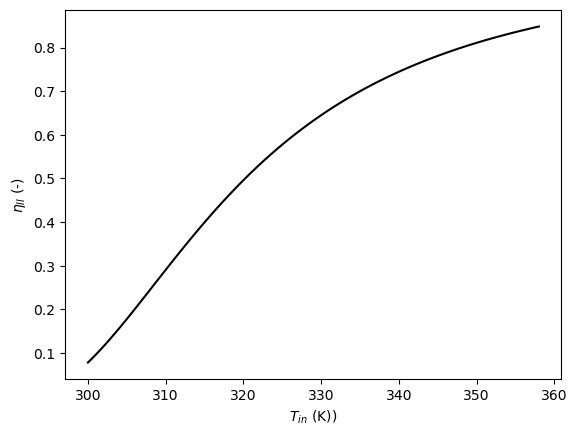

In [52]:
plt.figure()
plt.clf()
steps = 100

T = np.linspace(300, Tmax_K, steps) # range of temperatures
h0 = np.linspace(h0_kJperKg, h0_kJperKg, steps) # range of temperatures
T0 = np.linspace(T0_K, T0_K, steps)
s0 = np.linspace(s0_kJperKgperK, s0_kJperKgperK, steps)
Xel = np.linspace(Xel_W, Xel_W, steps)
P = np.linspace(P_W, P_W, steps)

sin = [s.s for s in [IAPWS97(T=t, P=p0_MPa) for t in T]]
hin = [s.h for s in [IAPWS97(T=t, P=p0_MPa) for t in T]]

sout = [s.s for s in [IAPWS97(T=t+dT_K, P=p0_MPa) for t in T]]
hout = [s.h for s in [IAPWS97(T=t+dT_K, P=p0_MPa) for t in T]]

Xdot_in = mdot_kgPers*(hin - h0 - T0*(sin - s0))
Xdot_out = mdot_kgPers*(hout - h0 - T0*(sout - s0))

eta = Xdot_out/(Xdot_in + (Xel/1000) + (P/1000))

plt.plot(T, eta, 'k-')

plt.xlabel('$T_{in}$ (K))')
plt.ylabel('$\eta_{II}$ (-)')
plt.savefig('eta-Tin.png')

This is simplified analysis, but it shows the plausibility of using hot water to cool electronics in order to facilitate heat reuse. This can minimize the overall system carbon footprint because the recovered heat can replace significant amounts of fossil fuels used in secondary applications such as building heating.